# Ensemble Models For Target Pregnancy Prediction Problem

This notebook is a follow-up to the first one, using linear models. In this notebook we will work on the same problem using enseble methods, namely bagging and boosting of simple stump predictors.

As weak learners we will use *stumps*. A *stump* is the most basic form of decision tree: it is based on only one feature and, in our case, it classifies an instance as pregnant or not pregant based on the binary value of the feature. For instance, a stump using the variable x = **Birth Control** would predict 1 (pregnant) if x = 1 and 0 otherwise.

### Summary
1. Import Necesessary Modules
2. Define The `Stump` Class Implementing Basic Stump Predictor
3. Define Teh `Bag` Class, a Boosting Aggregator of Stumps
4. Define The `Boost` Class, an Ada-Booster of Stumps
5. Use Case: Predicting Pregnancy On The Target Data Set
    * 4.1. Simple Stump
    * 4.2. Bagging
    * 4.3. AdaBoost
6. Conclusions

## Import all necesessary modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Define The `Stump` Class Implementing Basic Stump Predictor

The class implements a basic stump predictor, i.e. a tree that accepts only one binary feature as input and returns the predicted value of $y$. It has two methods: `fit` and `predict`. The `fit` method decides which value of x is the best predictor of the event $\{y = 1\}$ based on the *pregnancy rate* in the subsets $\{x = 0\}$ and $\{x = 1\}$, then it computes the Gini coefficient for this predictor. The `predict` method returns $x$ if the fitted model is $x=1 \rightarrow y=1$, $1-x$ otherwise.


In [9]:
class Stump:
    """
    Accepts only one binary feature x with values in {0, 1}.
    """
    
    def __init__(self):
        self.vote = None
        self.Gini = None
    
    def fit(self, x, y):
        p0 = np.sum(y[x==0]) / np.sum(x==0)
        p1 = np.sum(y[x==1]) / np.sum(x==1)
        w0 = np.sum(x==0) / len(x)        
        g0 = 2 * p0 * (1 - p0)
        g1 = 2 * p1 * (1 - p1)
        
        self.Gini = w0 * g0 + (1 - w0) * g1        
        self.vote = 1 if p0 <= p1 else 0

    def predict(self, x):
        # if x == 1 predicts y == 1 and just returns x
        # otherwise flip 0s and 1s
        assert (self.vote != None)
        if self.vote:
            return x
        else:
            return 1 - x

## 3. Define The `Bag` Class, a Boosting Aggregator of Stumps

The class impleents a bagging of stumps. The`fit` method performs the following:

* Extract a random subsample of rows and colums from $X$
* for $i = 1...N$:
    * extract from the subsample 4 features and fit a stump to each one
    * choose the one with whe lowest Gini and keep it
* At the end of the process we have $N$ weak learners stored in the `stumps` attribute.
 
The `predict` method aggregates each stump's prediction in the following manner:

* Let each stump predict based on his own feature
* For each observation sum the predicted values
* Assign the bagged predicted value equal to the majority vote

In [10]:
class Bag:
    def __init__(self, num_cols=None, num_rows=None):
        self.num_cols = num_cols
        self.num_rows = num_rows
        self.stumps = []        
            
    def fit(self, X, y, num_learners=100):
        if self.num_cols == None:
            self.num_cols = np.int(np.floor(np.sqrt(X.shape[1])))
            
        if self.num_rows == None:
            self.num_rows = np.int(np.floor(0.66 * X.shape[0]))
                   
        assert self.num_cols > 0
        assert self.num_rows > 0
        assert num_learners > 0
       
        # num_learners trials to choose best stump (based on Gini index) from 4 to add to weak learners list
        num_contestants = min(4, self.num_cols)
        for i in range(num_learners):
            col_sample = np.random.choice(range(X.shape[1]), size=self.num_cols, replace=False)
            contestant_cols = np.random.choice(col_sample, size=num_contestants, replace=False)

            X_sample = X.sample(n=self.num_rows).iloc[:, contestant_cols]
            y_sample = y[X_sample.index]
 
            contestants = []
            Gini = []
            
            for j in range(num_contestants):
                c = Stump()
                c.fit(X_sample.iloc[:, j], y_sample)
                contestants.append(c)
                Gini.append(c.Gini)
                               
            # choose stump with lower Gini inpurity
            winner_index = np.argmin(Gini)
            
            # save stump and relative feature number as a pair
            self.stumps.append((contestants[winner_index], contestant_cols[winner_index]))
            
    def predict(self, X, probs=True):
        votes = np.zeros(X.shape[0])
        for stump, col in self.stumps:
            votes += stump.predict(X.iloc[:, col])
        votes /= len(self.stumps)     
        if probs:
            return votes       
        else:
            return (votes >= 0.5).astype(int)

## 4. Define The `Boost` Class, an Ada-Booster of Stumps

The class implements AdaBoost for stumps.
The `fit` performs the basic AdaBoost algorithm (for details on the algorithm see for example [here](https://en.wikipedia.org/wiki/AdaBoost)):

* Start with equal weights $w_i = 1/N$ where $N$ is the number of observations
* While **Features** not empty:
    * Fit a stump to each feature in **Features**
    * Choose the one with lower exponential loss
    * Save it along with it's $\alpha$
    * Update weights inflating the observations where the chosen stump makes a wrong prediction
    * Discard the chosen feature from the **Features** list


At the end of the process we have $M$ weak learners stored in the `stumps` attribute (where $M$ denotes the number of features).
 
The `predict` method aggregates each stump's prediction in the following manner:

* Let each stump predict based on his own feature (rescale predictions on {-1,1} for convenience)
* Aggregate predictions weighted by their $\alpha$: $\hat{y_i} = F(x_i) = \sum_{k=1}^{M} \alpha_k S_k(x_i)$
+ Assign the bagged predicted value equal to 1 if $\hat{y_i}$ is positive, 0 if negative 


In [11]:
class Boost:
    def __init__(self):
        self.stumps = []
    
    def fit(self, X, y, tol=-np.inf):        
        # initializes uniform weights
        weights = np.ones(X.shape[0]) / X.shape[0]
        columns = [i for i in  range(X.shape[1])]
        contestants = [Stump() for _ in columns]

        while contestants:
            weighted_error = []
            for i in range(len(columns)):
                contestants[i].fit(X.iloc[:, columns[i]], y)
                weighted_error.append(np.sum(weights[y != contestants[i].predict(X.iloc[:, columns[i]])]))
           
            winner_index = np.argmin(weighted_error)   
            alpha = 0.5 * np.log((1-weighted_error[winner_index])/weighted_error[winner_index])
        
            wrong = (y != contestants[winner_index].predict(X.iloc[:, columns[winner_index]]))
            weights *= np.exp(alpha * wrong)
            weights /= np.sum(weights)
                        
            self.stumps.append((contestants.pop(winner_index), columns.pop(winner_index), alpha))

            if np.abs(weighted_error[winner_index] / 0.5 - 1) < tol:
                break
                        

    def predict(self, X, score=True):
        votes = np.zeros(X.shape[0])
        for stump, col, alpha in self.stumps:
            # adds stump's weighted prediction:
            # alpha if 1 predicted, -alpha if 0 predicted
            votes += alpha * (2 * stump.predict(X.iloc[:, col]) - 1)
            
            if score:
                return votes
            else:
                return (votes >= 0).astype(int)
        return votes

## 5. Use Case: Predicting Pregnancy On The Target Data Set

See part 1 for data analysis and manipulation.

In [2]:
# load dataset
preg = pd.read_excel('RetailMart.xlsx')
preg.drop('Unnamed: 17', inplace=True, axis=1)

In [3]:
preg['Male'] = (preg['Implied Gender'] == 'M').astype(int)
preg.drop(['Implied Gender', 'Home/Apt/ PO Box'], axis=1, inplace=True)
X = preg.drop('PREGNANT', axis=1)
y = preg['PREGNANT']

### 4.1. Simple Stump

It comes as no surprise that stumps are weak learners with accuracy and AUC slightly better than 50%.

In [12]:
# split train and test datasets
dim_train = 330
dim_test = 170 # c.a. 2/3 train, 1/3 test for each value of PREGNANT

X_train0 = X[y==0].sample(n=dim_train)
X_test0 = X[y==0].drop(X_train0.index, axis=0)

X_train1 = X[y==1].sample(n=dim_train)
X_test1 = X[y==1].drop(X_train1.index, axis=0)

X_train = X_train0.append(X_train1)
X_test = X_test0.append(X_test1)
y_train= y[X_train.index]
y_test = y[X_test.index]

In [15]:
# helper function to compute AUC and draw ROC curve
def auc(score, y_test, lower=-3, upper=3, bins=100, print_curve=False):
    s = np.linspace(lower, upper, bins)
    xx = []
    yy = []

    for cutoff in s:
        y_hat = (score > cutoff).astype(int)
        xx.append(sum(y_hat[y_test==0]==1) / sum(y_test==0))
        yy.append(sum(y_hat[y_test==1]==1) / sum(y_test==1))
    area=0
    for i in range(1, len(xx)):
        area += 0.5 * np.abs(xx[i] - xx[i-1]) * (yy[i-1] + yy[i])

    if print_curve:
        plt.plot(xx,yy)
        plt.fill_between(xx,yy, alpha=0.05)
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.xlabel("FPR (1 - specificity)")
        plt.ylabel("TPR (sensitivity)")
        plt.text(0.5,0.5,'AUC = {:.2f}%'.format(area*100), fontsize=16)
    else:
        return area

In [17]:
stump = Stump()
stump.fit(X_train['Pregnancy Test'], y_train)
p_hat = stump.predict(X_test['Pregnancy Test'])

In [18]:
y_hat = (p_hat > 0.5).astype(int)
Accuracy = np.mean(y_hat == y_test) # Accuracy
print('Accuracy(% correctly classified) = {:.2f}%'.format(Accuracy * 100))

Accuracy(% correctly classified) = 56.47%


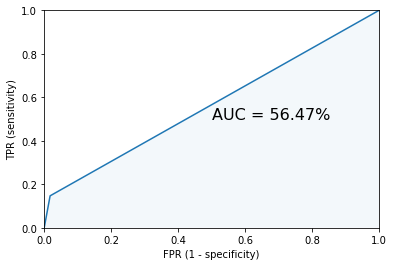

In [19]:
auc(p_hat,y_test,-1,1,100,True)

## 4.2. Bagging

The first enseble algorithm we try is bagging (*boosting aggregating*). We can see that performance strongly improves when compared to each individual stump.

In [20]:
rstump = Bag()
rstump.fit(X_train, y_train)
p_hat = rstump.predict(X_test)

In [21]:
y_hat = (p_hat > 0.5).astype(int)
Accuracy = np.mean(y_hat == y_test) # Accuracy
print('Accuracy(% correctly classified) = {:.2f}%'.format(Accuracy * 100))

Accuracy(% correctly classified) = 71.18%


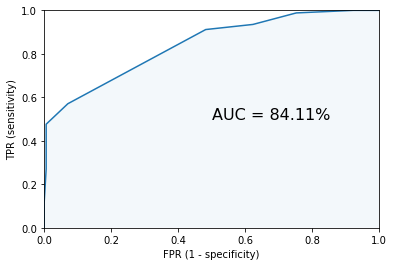

In [22]:
auc(p_hat,y_test,-3,3,100,True)

## 4.3. AdaBoost

Now let us try AdaBoost. AdaBoost weighs learners based on where they are more right so it should be *smarter* than a simple bagging.

In [23]:
bstump = Boost()
rstump.fit(X_train, y_train)
p_hat = rstump.predict(X_test)

In [24]:
y_hat = (p_hat > 0.5).astype(int)
Accuracy = np.mean(y_hat == y_test) # Accuracy
print('Accuracy(% correctly classified) = {:.2f}%'.format(Accuracy * 100))

Accuracy(% correctly classified) = 70.59%


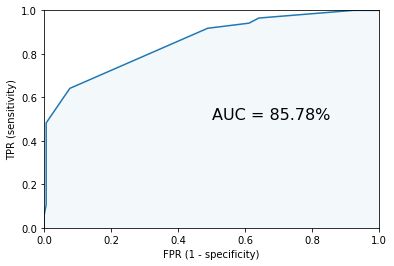

In [25]:
auc(p_hat,y_test,-3,3,100,True)

In fact the AUC increases slightly. It must be considered that we do not have that many features so there is not much boosting can do that bagging cannot.

## 6. Conclusions

After exploring our data set with both classical and *Machine-Learning* algorithms we can draw some (partial) conclusions:

- The best model was actually the simplest one, linear regression
- ML algorithms do not outperformed classical ones
- It must be noted, however, that bagging and boosting worked with extremely week learners. It is to be expected that a more refined bagging or boosting version (e.g. a Random Forest) would perform much better
- Also, consider the data set was simulated (probabily with a logistic)

I hope this notebooks were helpful. For more material on ML and Data Science check out my [blog](https://littlehelperscorner.wordpress.com/) and

<h2>Thank you for reading!</h2>